# The Price is Right

Today we build a more complex solution for estimating prices of goods.

1. This notebook: create a RAG database with our 400,000 training data
2. Day 2.1 notebook: visualize in 2D
3. Day 2.2 notebook: visualize in 3D
4. Day 2.3 notebook: build and test a RAG pipeline with GPT-4o-mini
5. Day 2.4 notebook: (a) bring back our Random Forest pricer (b) Create a Ensemble pricer that allows contributions from all the pricers

Phew! That's a lot to get through in one day!

## PLEASE NOTE:

We already have a very powerful product estimator with our proprietary, fine-tuned LLM. Most people would be very satisfied with that! The main reason we're adding these extra steps is to deepen your expertise with RAG and with Agentic workflows.

# Day 0 - Store the data to vector database

In [1]:
# imports
import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import numpy as np
import pickle
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from sklearn.manifold import TSNE
import plotly.graph_objects as go

In [2]:
# environment
load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')
DB = "products_vectorstore"

In [3]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [5]:
# Another import after Logging in to Hugging Face - thank you Trung N.!

from items import Item

## Back to the pkl files

Much as we enjoyed data curating in week 6, we probably don't want to go through that whole process again!

Let's reuse the pkl files we created then. Either copy the files `train.pkl` and `test.pkl` from the Week 6 folder into this Week 8 folder, or you can also download them from here:

https://drive.google.com/drive/folders/1f_IZGybvs9o0J5sb3xmtTEQB3BXllzrW?usp=drive_link

In [6]:
# With train.pkl in this folder, you can run this:

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

In [9]:
print(train[0].prompt)

How much does this cost to the nearest dollar?

Pacific Digital 4X External USB Dual Format DVD Drive
Product Description Burn your own CDs and DVDs or back up important files with ease using this Pacific Digital 4x Dual Format External DVD Burner. The full-featured software makes this one of the most versatile and universally compatible burners available. Features portable external design; back up from multiple systems; DVD+R/-RW, DVD-R/-RW, and CD-R/RW compatible; easily connects to PC or notebook; enough storage for more than 3,000 pictures; software for creating your own DVD movies or music CDs; and it works as a full-featured DVD player. From the Manufacturer Capture, Create, Convert, Watch. DVD+R/+RW, DVD-R/-RW and CD-R/RW recording together with a full

Price is $199.00


# Now create a Chroma Datastore

In Week 5, we created a Chroma datastore with 123 documents representing chunks of objects from our fictional company Insurellm.

Now we will create a Chroma datastore with 400,000 products from our training dataset! It's getting real!

Note that we won't be using LangChain, but the API is very straightforward and consistent with before.

Special note: if Chroma crashes and you're a Windows user, you should try rolling back to an earlier version of the Chroma library with:  
`!pip install chromadb==0.5.0`  
With many thanks to student Kelly Z. for finding this out and pointing to the GitHub issue [here](https://github.com/chroma-core/chroma/issues/2513). 
But try first without reverting Chroma.

In [10]:
client = chromadb.PersistentClient(path=DB)

In [11]:
client.list_collections()

[]

In [12]:
# Check if the collection exists and delete it if it does
collection_name = "products"

# For old versions of Chroma, use this line instead of the subsequent one
# existing_collection_names = [collection.name for collection in client.list_collections()]
existing_collection_names = client.list_collections()

if collection_name in existing_collection_names:
    client.delete_collection(collection_name)
    print(f"Deleted existing collection: {collection_name}")

collection = client.create_collection(collection_name)

# Introducing the SentenceTransfomer

The all-MiniLM is a very useful model from HuggingFace that maps sentences & paragraphs to a 384 dimensional dense vector space and is ideal for tasks like semantic search.

https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

It can run pretty quickly locally.

Last time we used OpenAI embeddings to produce vector embeddings. Benefits compared to OpenAI embeddings:
1. It's free and fast!
3. We can run it locally, so the data never leaves our box - might be useful if you're building a personal RAG


In [13]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [14]:
# Pass in a list of texts, get back a numpy array of vectors
vector = model.encode(["Well hi there"])[0]
vector

array([-9.46715996e-02,  4.27619368e-02,  5.51620498e-02, -5.10984682e-04,
        1.16203222e-02, -6.80130869e-02,  2.76405662e-02,  6.06974810e-02,
        2.88530700e-02, -1.74128059e-02, -4.94346544e-02,  2.30993349e-02,
       -1.28614362e-02, -4.31402884e-02,  2.17510164e-02,  4.26548682e-02,
        5.10500036e-02, -7.79726505e-02, -1.23247258e-01,  3.67455631e-02,
        4.54107625e-03,  9.47937965e-02, -5.53098805e-02,  1.70641448e-02,
       -2.92873289e-02, -4.47124913e-02,  2.06784271e-02,  6.39320537e-02,
        2.27427799e-02,  4.87789549e-02, -2.33501988e-03,  4.72859219e-02,
       -2.86259297e-02,  2.30624955e-02,  2.45130379e-02,  3.95682231e-02,
       -4.33176458e-02, -1.02316611e-01,  2.79877125e-03,  2.39304714e-02,
        1.61556322e-02, -8.99079628e-03,  2.07255930e-02,  6.40123263e-02,
        6.89179599e-02, -6.98360950e-02,  2.89763859e-03, -8.10989514e-02,
        1.71123147e-02,  2.50655157e-03, -1.06529057e-01, -4.87733334e-02,
       -1.67762376e-02, -

In [15]:
vector.shape

(384,)

#### Extra - function to compare vectors

In [16]:
# Quick sidebar - extra to the videos - a function to compare vectors
import numpy as np
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def how_similar(text1, text2):
    vector1, vector2 = model.encode([text1, text2])
    similarity = cosine_similarity(vector1, vector2)
    print(f"Similarity between {text1} and {text2} is {similarity*100:.1f}%")

In [17]:
# And let's see how adding a few words to the context can change things up!

how_similar("Java", "C++")
how_similar("Java", "mug")
how_similar("Cup of Java", "mug")

Similarity between Java and C++ is 50.7%
Similarity between Java and mug is 25.8%
Similarity between Cup of Java and mug is 49.3%


In [18]:
# OK back to the main story - let's make something we can vectorize

def description(item):
    text = item.prompt.replace("How much does this cost to the nearest dollar?\n\n", "")
    return text.split("\n\nPrice is $")[0]

In [22]:
print(train[0].prompt)

How much does this cost to the nearest dollar?

Pacific Digital 4X External USB Dual Format DVD Drive
Product Description Burn your own CDs and DVDs or back up important files with ease using this Pacific Digital 4x Dual Format External DVD Burner. The full-featured software makes this one of the most versatile and universally compatible burners available. Features portable external design; back up from multiple systems; DVD+R/-RW, DVD-R/-RW, and CD-R/RW compatible; easily connects to PC or notebook; enough storage for more than 3,000 pictures; software for creating your own DVD movies or music CDs; and it works as a full-featured DVD player. From the Manufacturer Capture, Create, Convert, Watch. DVD+R/+RW, DVD-R/-RW and CD-R/RW recording together with a full

Price is $199.00


In [20]:
print(description(train[0]))

Pacific Digital 4X External USB Dual Format DVD Drive
Product Description Burn your own CDs and DVDs or back up important files with ease using this Pacific Digital 4x Dual Format External DVD Burner. The full-featured software makes this one of the most versatile and universally compatible burners available. Features portable external design; back up from multiple systems; DVD+R/-RW, DVD-R/-RW, and CD-R/RW compatible; easily connects to PC or notebook; enough storage for more than 3,000 pictures; software for creating your own DVD movies or music CDs; and it works as a full-featured DVD player. From the Manufacturer Capture, Create, Convert, Watch. DVD+R/+RW, DVD-R/-RW and CD-R/RW recording together with a full


## Now we populate our RAG datastore

The next cell populates the 400,000 items in Chroma.

Feel free to reduce the number of documents if this takes too long! You can change to:  
`NUMBER_OF_DOCUMENTS = 20000`  
And that's plenty for a perfectly good RAG pipeline.

Just note that if you interrupt the below cell while it's running, you might need to clear out the Chroma datastore (by rerunning the earlier cell that deletes the collection), before you run it again. Otherwise it will complain that there are existing documents with the same ID.

In [23]:
NUMBER_OF_DOCUMENTS = len(train)

# Uncomment if you'd rather not wait for the full 400,000
# NUMBER_OF_DOCUMENTS = 20000

for i in tqdm(range(0, NUMBER_OF_DOCUMENTS, 1000)):
    documents = [description(item) for item in train[i: i+1000]]
    vectors = model.encode(documents).astype(float).tolist()
    metadatas = [{"category": item.category, "price": item.price} for item in train[i: i+1000]]
    ids = [f"doc_{j}" for j in range(i, i+len(documents))]
    collection.add(
        ids=ids,
        documents=documents,
        embeddings=vectors,
        metadatas=metadatas
    )

100%|██████████| 260/260 [19:25<00:00,  4.48s/it]


# Day 1 - Visualize in 2D 

In [ ]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import numpy as np
import pickle
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from sklearn.manifold import TSNE
import plotly.graph_objects as go

In [24]:
# It is very fun turning this up to 400_000 and seeing the full dataset visualized,
# but it almost crashes my box every time so do that at your own risk!! 10_000 is safe!

MAXIMUM_DATAPOINTS = 30_000

In [25]:
DB = "products_vectorstore"
client = chromadb.PersistentClient(path=DB)

In [26]:
collection = client.get_or_create_collection('products')

In [27]:
CATEGORIES = ['Appliances', 'Automotive', 'Cell_Phones_and_Accessories', 'Electronics','Musical_Instruments', 'Office_Products', 'Tools_and_Home_Improvement', 'Toys_and_Games']
COLORS = ['red', 'blue', 'brown', 'orange', 'yellow', 'green' , 'purple', 'cyan']

In [28]:
# Prework
result = collection.get(include=['embeddings', 'documents', 'metadatas'], limit=MAXIMUM_DATAPOINTS)
vectors = np.array(result['embeddings'])
documents = result['documents']
categories = [metadata['category'] for metadata in result['metadatas']]
colors = [COLORS[CATEGORIES.index(c)] for c in categories]

In [29]:
# Let's try a 2D chart

tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
reduced_vectors = tsne.fit_transform(vectors)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [30]:

# Create the 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=3, color=colors, opacity=0.7),
)])

fig.update_layout(
    title='2D Chroma Vectorstore Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y'),
    width=1200,
    height=800,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

# Day 2 - Visualize the data in 3D 

In [31]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import numpy as np
import pickle
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from sklearn.manifold import TSNE
import plotly.graph_objects as go

In [32]:
# Turn this up at your own risk! 10_000 is safe..

MAXIMUM_DATAPOINTS = 20_000

In [33]:
DB = "products_vectorstore"
client = chromadb.PersistentClient(path=DB)

In [34]:
collection = client.get_or_create_collection('products')

In [35]:
CATEGORIES = ['Appliances', 'Automotive', 'Cell_Phones_and_Accessories', 'Electronics','Musical_Instruments', 'Office_Products', 'Tools_and_Home_Improvement', 'Toys_and_Games']
COLORS = ['red', 'blue', 'brown', 'orange', 'yellow', 'green' , 'purple', 'cyan']

In [36]:
# Prework
result = collection.get(include=['embeddings', 'documents', 'metadatas'], limit=MAXIMUM_DATAPOINTS)
vectors = np.array(result['embeddings'])
documents = result['documents']
categories = [metadata['category'] for metadata in result['metadatas']]
colors = [COLORS[CATEGORIES.index(c)] for c in categories]

In [37]:
# Let's try 3D!

tsne = TSNE(n_components=3, random_state=42, n_jobs=-1)
reduced_vectors = tsne.fit_transform(vectors)

In [38]:

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=3, color=colors, opacity=0.7),
)])

fig.update_layout(
    title='3D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    width=1200,
    height=800,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

# Day 3 - Build the RAG pipeline 

In [39]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from testing import Tester

In [40]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [41]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: Environment variable`H

In [42]:
# Another import after Logging in to Hugging Face - thank you Trung N.!

from items import Item

In [43]:
openai = OpenAI()

In [44]:
# Load in the test pickle file
# See the section "Back to the PKL files" in the day2.0 notebook
# for instructions on obtaining this test.pkl file

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [45]:
def make_context(similars, prices):
    message = "To provide some context, here are some other items that might be similar to the item you need to estimate.\n\n"
    for similar, price in zip(similars, prices):
        message += f"Potentially related product:\n{similar}\nPrice is ${price:.2f}\n\n"
    return message

In [46]:
def messages_for(item, similars, prices):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = make_context(similars, prices)
    user_prompt += "And now the question for you:\n\n"
    user_prompt += item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [47]:
DB = "products_vectorstore"

In [48]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [49]:
def description(item):
    text = item.prompt.replace("How much does this cost to the nearest dollar?\n\n", "")
    return text.split("\n\nPrice is $")[0]

In [50]:
description(test[0])

"Nadair 22 LED Under Cabinet Lighting Kit Swivel Plug-In Ultra-Slim Closet or Kitchen Cabinet Light Dimmable With 3 Color Modes Built-In, Linkable\n22 LED UNDERCABINET SWIVELING LIGHT BAR - Perfect light fixture to illuminate cabinets, as well recessed areas, desks or work spaces. CHOOSE FROM 3 COLOR TEMPERATURE MODES - Easily switch color from 2700K soft white, 3500K warm white and 4000K cool white to set the right mood for any occasion. SWIVEL - Light can be directed to a specific area with the light bar's built-in swiveling function. QUICK & EASY INSTALLATION - Pre-installed screws to make installation a breeze. — Mount lights yourself in just a few"

In [51]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [52]:
def vector(item):
    return model.encode([description(item)])

In [53]:
def find_similars(item):
    results = collection.query(query_embeddings=vector(item).astype(float).tolist(), n_results=5)
    documents = results['documents'][0][:]
    prices = [m['price'] for m in results['metadatas'][0][:]]
    return documents, prices

In [54]:
print(test[1].prompt)

How much does this cost to the nearest dollar?

Touch of Class Piala Pineapple Table Lamp Green - Handcrafted Stained Glass - Tropical Theme Decor - Beach Bedroom Lamps - Themed Accents for Living Room, Office Desk - Tiffany Style
🍍 SIGNATURE SELECTION 🍍 - Designed with you in mind, this pineapple decor lamp is our exclusive, which means you won't find a lighting experience like this one anywhere else. You are worthy of a table accent as unique as you. Decorate your home with playful distinction. 🍍SIGHTWORTHY AMBIENCE 🍍 - Imagine for a moment, lounging in the living room on a chair, relaxing bedside taking a nap or in your study reading a book. Now, picture an extraordinary tropical paradise landing wonderfully on your desk. Transport yourselves into

Price is $320.00


In [55]:
documents, prices = find_similars(test[1])

In [56]:
print(make_context(documents, prices))

To provide some context, here are some other items that might be similar to the item you need to estimate.

Potentially related product:
Touch of Class Tropical Passion Stained Glass Table Lamp - Multi Pastel - Handcrafted - Tiffany Style Decor - Tropics Desk Accent - Antique Flower Lamps for Bedroom, Living Room, Foyer
🏵️ SIGNATURE SELECTION 🏵️ - Selected with you in mind, this gorgeous lamp is one of our favorites. Without a doubt in our heart, we believe you are worthy of table decor as unique, wonderful and elegant as you. Decorate your household atmosphere with distinction and delight. 🏵️ SPLENDOROUS FLORALS 🏵️ - Imagine for a moment, relaxing in the bedroom, lounging on your favorite chair in the living room or reading a novel within your study and before you is a beautiful lighting arrangement, naturally formed into one
Price is $239.99

Potentially related product:
Touch of Class Zuri Stained Glass Vase Shaped Floral Uplight Accent Table Lamp - Pink, Purple, Burgundy, Green - T

In [57]:
print(messages_for(test[1], documents, prices))

[{'role': 'system', 'content': 'You estimate prices of items. Reply only with the price, no explanation'}, {'role': 'user', 'content': "To provide some context, here are some other items that might be similar to the item you need to estimate.\n\nPotentially related product:\nTouch of Class Tropical Passion Stained Glass Table Lamp - Multi Pastel - Handcrafted - Tiffany Style Decor - Tropics Desk Accent - Antique Flower Lamps for Bedroom, Living Room, Foyer\n🏵️ SIGNATURE SELECTION 🏵️ - Selected with you in mind, this gorgeous lamp is one of our favorites. Without a doubt in our heart, we believe you are worthy of table decor as unique, wonderful and elegant as you. Decorate your household atmosphere with distinction and delight. 🏵️ SPLENDOROUS FLORALS 🏵️ - Imagine for a moment, relaxing in the bedroom, lounging on your favorite chair in the living room or reading a novel within your study and before you is a beautiful lighting arrangement, naturally formed into one\nPrice is $239.99\n\n

In [58]:
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [59]:
get_price("The price for this is $99.99")

99.99

In [60]:
# The function for gpt-4o-mini

def gpt_4o_mini_rag(item):
    documents, prices = find_similars(item)
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item, documents, prices),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [61]:
gpt_4o_mini_rag(test[1])

249.99

In [62]:
test[1].price

319.99

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


1: Guess: $45.99 Truth: $51.18 Error: $5.19 SLE: 0.01 Item: Nadair 22" LED Under Cabinet Lighting Ki...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


2: Guess: $249.99 Truth: $319.99 Error: $70.00 SLE: 0.06 Item: Touch of Class Piala Pineapple Table Lam...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


3: Guess: $49.99 Truth: $137.54 Error: $87.55 SLE: 1.00 Item: Legrand - OnQ Desk Mount Power Supply, P...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


4: Guess: $503.97 Truth: $470.33 Error: $33.64 SLE: 0.00 Item: Moen TS44503BG Colinet Two Deck-Mount Ro...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


5: Guess: $91.97 Truth: $57.97 Error: $34.00 SLE: 0.21 Item: ShowerMaxx, Elite Series, 6 Spray Settin...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


6: Guess: $19.99 Truth: $28.77 Error: $8.78 SLE: 0.12 Item: Cenipar WD08X10057 Dishwasher Door Gaske...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


7: Guess: $24.99 Truth: $14.90 Error: $10.09 SLE: 0.24 Item: Belkin 15.4-Inch Neoprene Sleeve (Black/...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


8: Guess: $222.02 Truth: $224.00 Error: $1.98 SLE: 0.00 Item: TOTO UT447E#01 Commercial Washout Urinal...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


9: Guess: $49.99 Truth: $29.00 Error: $20.99 SLE: 0.28 Item: DC Programmable Meter Controller 0-200V ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


10: Guess: $49.99 Truth: $144.08 Error: $94.09 SLE: 1.09 Item: Gezhesiwei 50Pack Soft Close Hinges Full...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


11: Guess: $10.99 Truth: $14.99 Error: $4.00 SLE: 0.08 Item: We Love You to The Moon and Back Stars C...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


12: Guess: $62.99 Truth: $39.00 Error: $23.99 SLE: 0.22 Item: Stupell Industries Antique Florida Map R...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


13: Guess: $149.99 Truth: $136.06 Error: $13.93 SLE: 0.01 Item: Alpine Electronics BBX-F1200 4 Channel A...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


14: Guess: $159.00 Truth: $149.00 Error: $10.00 SLE: 0.00 Item: Countertop Water Distiller Machine- Stai...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


15: Guess: $91.45 Truth: $184.80 Error: $93.35 SLE: 0.49 Item: Allied Brass WP-72/30 Waverly Place Coll...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


16: Guess: $299.99 Truth: $179.99 Error: $120.00 SLE: 0.26 Item: Lenovo L24q-30 23.8-inch QHD (2560 x 144...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


17: Guess: $136.99 Truth: $136.00 Error: $0.99 SLE: 0.00 Item: LCDOLED® 13.3 inch QHD+ 3200x1800 LED LC...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


18: Guess: $175.99 Truth: $219.99 Error: $44.00 SLE: 0.05 Item: hizpo 7 Inch IPS HD Screen Car Stereo fo...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


19: Guess: $299.00 Truth: $173.90 Error: $125.10 SLE: 0.29 Item: MILWAUKEE'S Cutoff/Grinder, Slide, Bare ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


20: Guess: $59.99 Truth: $42.69 Error: $17.30 SLE: 0.11 Item: Maxbilt Drill and Drive Set 109 Pieces


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


21: Guess: $1,049.00 Truth: $739.99 Error: $309.01 SLE: 0.12 Item: SkyTech Shadow 3.0 Gaming Computer PC De...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


22: Guess: $37.99 Truth: $37.55 Error: $0.44 SLE: 0.00 Item: Proline Sculpted Keyboard Wrist Rest, Bl...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


23: Guess: $28.99 Truth: $112.74 Error: $83.75 SLE: 1.78 Item: Multifunctional Transistor Tester, TSH-0...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


24: Guess: $99.99 Truth: $115.00 Error: $15.01 SLE: 0.02 Item: AMD Ryzen 3 1200 Desktop Processor with ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


25: Guess: $178.99 Truth: $136.65 Error: $42.34 SLE: 0.07 Item: JONATHAN Y JYL9072B Stella 12" Moravian ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


26: Guess: $45.32 Truth: $62.42 Error: $17.10 SLE: 0.10 Item: Daydream Education Psychological Investi...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


27: Guess: $229.00 Truth: $343.00 Error: $114.00 SLE: 0.16 Item: Tele Vue 2x Powermate, 2" Image Amplifie...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


28: Guess: $99.99 Truth: $24.99 Error: $75.00 SLE: 1.84 Item: Mount-It! Anti-Theft iPad Pro Wall Mount...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


29: Guess: $79.95 Truth: $88.10 Error: $8.15 SLE: 0.01 Item: Ingersoll Rand - Rebuild Kit 2141 (2141-...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


30: Guess: $199.00 Truth: $164.99 Error: $34.01 SLE: 0.03 Item: Ruckus ZoneFlex H510 Wireless Wall Switc...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


31: Guess: $299.99 Truth: $285.62 Error: $14.37 SLE: 0.00 Item: OEF Furnishings Floor Standing Lectern P...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


32: Guess: $389.20 Truth: $678.95 Error: $289.75 SLE: 0.31 Item: WAC Lighting dweLED, Corso 32in LED Pend...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


33: Guess: $37.88 Truth: $43.88 Error: $6.00 SLE: 0.02 Item: POWERSTAR 12V 15AH Compatible with APC S...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


34: Guess: $2.99 Truth: $2.99 Error: $0.00 SLE: 0.00 Item: On-Q, Black WP3461BK RCA to FConnector, ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


35: Guess: $46.99 Truth: $46.99 Error: $0.00 SLE: 0.00 Item: LD Remanufactured Ink Cartridge Replacem...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


36: Guess: $99.99 Truth: $149.73 Error: $49.74 SLE: 0.16 Item: SK 3919 19 Piece 3/8-Inch Drive 6 Point ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


37: Guess: $329.99 Truth: $199.00 Error: $130.99 SLE: 0.25 Item: APEC Water Systems TANK-20 20 Gallon Pre...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


38: Guess: $209.99 Truth: $197.00 Error: $12.99 SLE: 0.00 Item: UNI-T Portable Digital Intelligent Multi...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


39: Guess: $399.00 Truth: $399.00 Error: $0.00 SLE: 0.00 Item: Pacific Coast Lighting Basque Brushed Ni...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


40: Guess: $179.00 Truth: $112.97 Error: $66.03 SLE: 0.21 Item: Fujifilm Instax Wide 300 Instant Film Ca...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


41: Guess: $57.88 Truth: $62.14 Error: $4.26 SLE: 0.00 Item: Avery Heavy-Duty View 3 Ring Binder, 3" ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


42: Guess: $12.50 Truth: $8.99 Error: $3.51 SLE: 0.09 Item: ZZHXSM Antique Embossing Decorative Zinc...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


43: Guess: $89.99 Truth: $79.99 Error: $10.00 SLE: 0.01 Item: 2023 HUION Inspiroy 2 Medium Drawing Tab...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


44: Guess: $574.95 Truth: $596.95 Error: $22.00 SLE: 0.00 Item: NIKKOR Z MC 50mm f/2.8


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


45: Guess: $178.00 Truth: $113.47 Error: $64.53 SLE: 0.20 Item: Golden Lighting 7151-SF WG Bellare Semi-...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


46: Guess: $699.99 Truth: $649.99 Error: $50.00 SLE: 0.01 Item: ASUS TUF Gaming NVIDIA GeForce RTX™ 4070...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


47: Guess: $49.99 Truth: $51.99 Error: $2.00 SLE: 0.00 Item: HOT Dog SWOOPER Flag Pack of 3 (Mount an...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


48: Guess: $34.99 Truth: $48.90 Error: $13.91 SLE: 0.11 Item: USB Charger for Zebra TC51, TC52, TC56, ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


49: Guess: $204.00 Truth: $204.00 Error: $0.00 SLE: 0.00 Item: Ceramic Tile Mural - Birdhouse and Herbs...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


50: Guess: $239.90 Truth: $271.90 Error: $32.00 SLE: 0.02 Item: Puluomis 24-Inch Bathroom Vanity with Wh...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


51: Guess: $75.46 Truth: $67.25 Error: $8.21 SLE: 0.01 Item: KOHLER 6389-ST Sink Rack for K-3356 Unde...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


52: Guess: $169.00 Truth: $159.00 Error: $10.00 SLE: 0.00 Item: Sena Adult SF2 Motorcycle Bluetooth Comm...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


53: Guess: $119.99 Truth: $153.99 Error: $34.00 SLE: 0.06 Item: DS-2CD2347G2-LU 4MP IP 247 Full Color 2....


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


54: Guess: $95.99 Truth: $279.99 Error: $184.00 SLE: 1.13 Item: HQ Products Remanufactured Toner Cartrid...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


55: Guess: $19.99 Truth: $20.74 Error: $0.75 SLE: 0.00 Item: Cameron Sino Li-ion 3.00V 1100mAh/3.30Wh...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


56: Guess: $27.99 Truth: $42.93 Error: $14.94 SLE: 0.17 Item: MAXTOOL 1/2" 2pcs Identical Jobber Lengt...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


57: Guess: $42.99 Truth: $78.95 Error: $35.96 SLE: 0.36 Item: Ford Econoline Van (E150~E250~E350) Keye...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


58: Guess: $178.99 Truth: $198.86 Error: $19.87 SLE: 0.01 Item: MSI ATX DDR3 2600 LGA 1150 Motherboard, ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


59: Guess: $399.99 Truth: $438.50 Error: $38.51 SLE: 0.01 Item: Hunter Fan Company 59484 Romulus Ceiling...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


60: Guess: $88.00 Truth: $184.00 Error: $96.00 SLE: 0.54 Item: Fingerprint Door Lock,Neuesbox Biometric...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


61: Guess: $99.95 Truth: $62.14 Error: $37.81 SLE: 0.22 Item: DIAL MANUFACTURING 3078 Dial Dura Cool R...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


62: Guess: $199.99 Truth: $230.72 Error: $30.73 SLE: 0.02 Item: Chief Mfg.Swing-Arm Wall Mount Hardware ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


63: Guess: $22.99 Truth: $5.49 Error: $17.50 SLE: 1.71 Item: 58mm Pro Series Multi-Coated High Resolu...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


64: Guess: $379.98 Truth: $220.78 Error: $159.20 SLE: 0.29 Item: HP Stream 14-inch Laptop, Intel Celeron ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


65: Guess: $48.99 Truth: $48.78 Error: $0.21 SLE: 0.00 Item: GDHXW 248213 Pump Repair Kit for Airless...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


66: Guess: $12.99 Truth: $2.99 Error: $10.00 SLE: 1.57 Item: Five Days Until You (One Week Girlfriend...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


67: Guess: $599.99 Truth: $895.95 Error: $295.96 SLE: 0.16 Item: Second Amendment 60minutes Fire-Resistan...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


68: Guess: $34.36 Truth: $42.66 Error: $8.30 SLE: 0.04 Item: MegaGear Ever Ready Leather Camera Case ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


69: Guess: $399.99 Truth: $479.99 Error: $80.00 SLE: 0.03 Item: ASUS LGA2011-v3 5-Way Optimization SafeS...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


70: Guess: $55.88 Truth: $81.95 Error: $26.07 SLE: 0.14 Item: Cubitron II 3M Roloc Fibre Disc 501C, Fi...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


71: Guess: $89.99 Truth: $103.98 Error: $13.99 SLE: 0.02 Item: WoodRiver Universal Vise


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


72: Guess: $28.62 Truth: $27.99 Error: $0.63 SLE: 0.00 Item: 3dRose LLC db_157653_1 Drawing Book, 8 b...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


73: Guess: $14.99 Truth: $2.90 Error: $12.09 SLE: 1.99 Item: Oregon 30-430 Lawn Mower Air Filters


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


74: Guess: $499.00 Truth: $677.51 Error: $178.51 SLE: 0.09 Item: Clear One 910-158-500-00 Max Ex Tabletop...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


75: Guess: $184.95 Truth: $191.70 Error: $6.75 SLE: 0.00 Item: Woodbridge Lighting 13224MEB-M20AMB Vene...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


76: Guess: $276.60 Truth: $276.60 Error: $0.00 SLE: 0.00 Item: Workrite Pinnacle 2 Value Arm w/17" nylo...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


77: Guess: $199.99 Truth: $239.99 Error: $40.00 SLE: 0.03 Item: Sony DCR-SR200 2.1MP 40GB Hard Disk Driv...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


78: Guess: $149.99 Truth: $300.00 Error: $150.01 SLE: 0.48 Item: SOTA Reflex-Clamp Record Clamping device...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


79: Guess: $149.99 Truth: $39.99 Error: $110.00 SLE: 1.70 Item: SabertoothPro VC550 AutoPod Motorized Ha...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


80: Guess: $159.00 Truth: $86.45 Error: $72.55 SLE: 0.36 Item: EARTEC MXS4XLR/F MAX 4G Single-Ear Heads...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


81: Guess: $498.99 Truth: $799.99 Error: $301.00 SLE: 0.22 Item: 13.3 inch Android Car Stereo Radio GPS N...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


82: Guess: $114.99 Truth: $149.33 Error: $34.34 SLE: 0.07 Item: Magic Chef MCIM22W 10 Portable Ice Maker...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


83: Guess: $276.99 Truth: $291.99 Error: $15.00 SLE: 0.00 Item: IKXO Waterproof Bone Conduction Headphon...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


84: Guess: $55.99 Truth: $83.32 Error: $27.33 SLE: 0.15 Item: HP Power Supply for HP Part Number 45532...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


85: Guess: $195.30 Truth: $279.00 Error: $83.70 SLE: 0.13 Item: Bang & Olufsen Beosound A1 (2nd Generati...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


86: Guess: $399.99 Truth: $600.54 Error: $200.55 SLE: 0.16 Item: Dura Heat Fireplace Log Set, 24 inch


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


87: Guess: $89.99 Truth: $77.99 Error: $12.00 SLE: 0.02 Item: Fitness Band, Vivosmart 3, Black, Large


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


88: Guess: $41.00 Truth: $28.47 Error: $12.53 SLE: 0.13 Item: Eiko EKE Halogen Dichroic Reflector Bulb...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


89: Guess: $189.97 Truth: $179.97 Error: $10.00 SLE: 0.00 Item: Luxorro Full Grain Leather Black Briefca...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


90: Guess: $64.99 Truth: $98.99 Error: $34.00 SLE: 0.17 Item: OPKMB Black Pendant Lighting Industrial ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


91: Guess: $178.99 Truth: $179.99 Error: $1.00 SLE: 0.00 Item: Artika Bi-Plan Modern Pendant Light LED,...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


92: Guess: $158.88 Truth: $279.99 Error: $121.11 SLE: 0.32 Item: Stealth Cam DS4K Ultimate Camera 32 Mega...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


93: Guess: $249.99 Truth: $299.00 Error: $49.01 SLE: 0.03 Item: INNOCN Portable Monitor 15.6" OLED 1080P...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


94: Guess: $599.99 Truth: $379.99 Error: $220.00 SLE: 0.21 Item: HP 15 Business Laptop, 15.6" FHD Micro-E...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


95: Guess: $19.42 Truth: $8.05 Error: $11.37 SLE: 0.66 Item: 3drose Think Like A Proton and Stay Posi...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


96: Guess: $299.99 Truth: $127.17 Error: $172.82 SLE: 0.73 Item: Sony DPP-EX5 Digital Photo Printer


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


97: Guess: $24.99 Truth: $17.99 Error: $7.00 SLE: 0.10 Item: BOO ACE 2B Anime Mouse Pads with Wrist R...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


98: Guess: $139.99 Truth: $169.98 Error: $29.99 SLE: 0.04 Item: JESLED 8FT LED Bulbs, Single Pin Fa8 Bas...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


99: Guess: $36.99 Truth: $168.95 Error: $131.96 SLE: 2.24 Item: Steelex M1037 Quick Change Collet Set fo...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


100: Guess: $528.99 Truth: $349.99 Error: $179.00 SLE: 0.17 Item: Konftel 300Wx Wireless Conference Phone ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


101: Guess: $109.99 Truth: $250.89 Error: $140.90 SLE: 0.67 Item: Bykski PC Water Liquid Cooling DDC Pump ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


102: Guess: $22.99 Truth: $19.49 Error: $3.50 SLE: 0.02 Item: Timbermate Rustic Ebony Hardwood Wood Fi...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


103: Guess: $249.99 Truth: $126.80 Error: $123.19 SLE: 0.46 Item: Acer Nitro XFA243Y Sbiipr 23.8” Full HD ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


104: Guess: $88.99 Truth: $86.99 Error: $2.00 SLE: 0.00 Item: NUNET LED Flame Tiki Torch Outdoor Bluet...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


105: Guess: $214.67 Truth: $235.17 Error: $20.50 SLE: 0.01 Item: Rain Guard Water Sealers VG-7002 VandlGu...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


106: Guess: $145.99 Truth: $110.79 Error: $35.20 SLE: 0.07 Item: Warehouse of Tiffany Melissa Crystal Cha...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


107: Guess: $159.99 Truth: $197.17 Error: $37.18 SLE: 0.04 Item: Brydge SP MAX+ Rugged Keyboard and Case ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


108: Guess: $189.00 Truth: $191.99 Error: $2.99 SLE: 0.00 Item: Dell Latitude E6420 14.1in HD Business L...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


109: Guess: $349.00 Truth: $385.00 Error: $36.00 SLE: 0.01 Item: CarPlay 6.5" Car Stereo MIB2 RCD330 RCD3...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


110: Guess: $139.99 Truth: $131.99 Error: $8.00 SLE: 0.00 Item: YESWELDER Spool Gun, 150 A, 10 FT Cable ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


111: Guess: $99.99 Truth: $91.89 Error: $8.10 SLE: 0.01 Item: Sylvania SDVD7750 Dual 7-Inch Portable L...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


112: Guess: $29.99 Truth: $38.99 Error: $9.00 SLE: 0.07 Item: 2023 Upgraded 800393, 800306, 831932, 46...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


113: Guess: $179.99 Truth: $179.99 Error: $0.00 SLE: 0.00 Item: 20 Pack LED 5/6" Inch Slim Disk LED, Dim...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


114: Guess: $9.99 Truth: $3.00 Error: $6.99 SLE: 1.02 Item: Ultimate Guards Beckett Shield Thick Car...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


115: Guess: $749.00 Truth: $399.00 Error: $350.00 SLE: 0.40 Item: Fujinon XF16mmF2.8 R WR Lens - Black


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


116: Guess: $3.59 Truth: $1.99 Error: $1.60 SLE: 0.18 Item: Avery Big Tab Insertable Dividers, Buff ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


117: Guess: $45.99 Truth: $107.95 Error: $61.96 SLE: 0.71 Item: ERASER KIT (COMPOSITE)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


118: Guess: $152.88 Truth: $150.88 Error: $2.00 SLE: 0.00 Item: Acoustic Audio R191 in Ceiling/in Wall S...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


119: Guess: $12.50 Truth: $0.90 Error: $11.60 SLE: 3.84 Item: Bud Industries IPG-22294-G IP66 TUV Long...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


120: Guess: $399.99 Truth: $439.94 Error: $39.95 SLE: 0.01 Item: Wet Sounds Non Amplified Stealth 6 V2 Pa...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


121: Guess: $399.99 Truth: $168.70 Error: $231.29 SLE: 0.74 Item: Brightlink 455WI Plus Rm Easiteach Softw...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


122: Guess: $24.99 Truth: $29.99 Error: $5.00 SLE: 0.03 Item: 65W Watt USB Type C AC Charger Fit for D...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


123: Guess: $172.48 Truth: $189.98 Error: $17.50 SLE: 0.01 Item: Thomas and Betts TR TY28MX Cable TIE 50L...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


124: Guess: $449.00 Truth: $418.00 Error: $31.00 SLE: 0.01 Item: hansgrohe Shower Set AXOR CITTERIO m Rai...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


125: Guess: $7.99 Truth: $3.90 Error: $4.09 SLE: 0.37 Item: National Hardware N830-197 512R5/8 Door ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


126: Guess: $64.99 Truth: $72.99 Error: $8.00 SLE: 0.01 Item: LD Remanufactured Ink Cartridge Replacem...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


127: Guess: $239.00 Truth: $149.00 Error: $90.00 SLE: 0.22 Item: CZUR Shine 800A3 Surface Pro Professiona...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


128: Guess: $349.00 Truth: $553.00 Error: $204.00 SLE: 0.21 Item: HPRC 27300W Wheeled Hard Case for Atomos...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


129: Guess: $139.99 Truth: $104.44 Error: $35.55 SLE: 0.08 Item: ASUS Prime H510M-E LGA1200 (Intel® 11th/...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


130: Guess: $97.12 Truth: $47.42 Error: $49.70 SLE: 0.50 Item: Filterbuy 25x25x2 Air Filter MERV 13 Opt...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


131: Guess: $41.99 Truth: $75.60 Error: $33.61 SLE: 0.33 Item: Remanufactured HP 910XL Ink Cartridge Wo...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


132: Guess: $99.99 Truth: $71.47 Error: $28.52 SLE: 0.11 Item: Kingston Brass DTT2161 Tip-Toe Bath Tub ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


133: Guess: $479.99 Truth: $669.99 Error: $190.00 SLE: 0.11 Item: Dell Inspiron 5000 Intel Core i3-8130U 1...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


134: Guess: $182.71 Truth: $174.99 Error: $7.72 SLE: 0.00 Item: Hunter Fan Company, 53312, 52 inch Newso...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


135: Guess: $49.99 Truth: $54.95 Error: $4.96 SLE: 0.01 Item: Philips All Multi Region Code Zone Free ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


136: Guess: $49.99 Truth: $60.99 Error: $11.00 SLE: 0.04 Item: Axis Communications T94T01D Pendant Kit ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


137: Guess: $119.99 Truth: $101.34 Error: $18.65 SLE: 0.03 Item: Carl MFG Heavy-Duty Punch, 2-Hole, 6mm, ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


138: Guess: $249.00 Truth: $199.00 Error: $50.00 SLE: 0.05 Item: ISEEVY 4x4 HDMI Matrix Switch with HDMI ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


139: Guess: $399.99 Truth: $229.00 Error: $170.99 SLE: 0.31 Item: IRIScan Desk 6 Pro-Professional Color Do...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


140: Guess: $469.99 Truth: $649.93 Error: $179.94 SLE: 0.10 Item: Apple MacBook Pro ME874LL/A Intel Core i...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


141: Guess: $30.99 Truth: $57.99 Error: $27.00 SLE: 0.37 Item: DC97-14486A Heating Element Assembly Dry...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


142: Guess: $97.99 Truth: $161.94 Error: $63.95 SLE: 0.25 Item: CANARM | Cain Vanity Light | IVL1019A03B...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


143: Guess: $59.99 Truth: $75.96 Error: $15.97 SLE: 0.05 Item: Sony NPFH70 H Series Actiforce Hybrid In...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


144: Guess: $499.99 Truth: $499.99 Error: $0.00 SLE: 0.00 Item: BOOX Tab Ultra B/W ePaper Tablet PC 10.3...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


145: Guess: $225.00 Truth: $185.30 Error: $39.70 SLE: 0.04 Item: Maxim 57764WTBZ Sky Energy Star JA8 Comp...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


146: Guess: $109.99 Truth: $363.00 Error: $253.01 SLE: 1.41 Item: Lenovo ThinkPad Mini Dock Plus Series 3 ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


147: Guess: $72.45 Truth: $71.43 Error: $1.02 SLE: 0.00 Item: Kohler K-23292-BN Square Toilet Tissue H...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


148: Guess: $284.00 Truth: $268.00 Error: $16.00 SLE: 0.00 Item: Billingham Hadley Small Pro Camera Bag (...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


149: Guess: $499.99 Truth: $549.95 Error: $49.96 SLE: 0.01 Item: 2021 Apple iPad Mini 6 (8.3 inch, Wi-Fi ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


150: Guess: $119.99 Truth: $115.99 Error: $4.00 SLE: 0.00 Item: Farmhouse Lighting Rustic Chandelier Din...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


151: Guess: $114.99 Truth: $152.17 Error: $37.18 SLE: 0.08 Item: Xerox VersaLink C500 /C505 Cyan Standard...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


152: Guess: $41.99 Truth: $47.29 Error: $5.30 SLE: 0.01 Item: Wiss WC3S 3-Blade 1-1/4-Inch Depth - HVA...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


153: Guess: $109.99 Truth: $95.99 Error: $14.00 SLE: 0.02 Item: Maxax Traditional Table Lamps Set of 2, ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


154: Guess: $478.75 Truth: $350.55 Error: $128.20 SLE: 0.10 Item: Kaba 1011-26D-41 Cylindrical Pushbutton ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


155: Guess: $82.99 Truth: $61.89 Error: $21.10 SLE: 0.08 Item: Etechwork Compatible Toner Cartridges Re...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


156: Guess: $142.95 Truth: $133.00 Error: $9.95 SLE: 0.01 Item: Kenwood KSC-SW11 Compact Powered Enclose...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


157: Guess: $209.99 Truth: $209.99 Error: $0.00 SLE: 0.00 Item: Maxquall Soccer Ref-comm Headset 3 Refer...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


158: Guess: $44.99 Truth: $30.99 Error: $14.00 SLE: 0.13 Item: 2 Pack - Replacement for Motorola HNN814...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


159: Guess: $299.99 Truth: $297.22 Error: $2.77 SLE: 0.00 Item: JBL Basspro Micro - Dockable powered sub...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


160: Guess: $25.99 Truth: $27.63 Error: $1.64 SLE: 0.00 Item: 1.25in 8-24mm Zoom Eyepiece Multi Coated...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


161: Guess: $329.95 Truth: $194.01 Error: $135.94 SLE: 0.28 Item: Fotodiox Pro TLT ROKR - Tilt/Shift Lens ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


162: Guess: $134.95 Truth: $87.00 Error: $47.95 SLE: 0.19 Item: KODAK PIXPRO FZ45-RD 16MP Digital Camera...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


163: Guess: $34.99 Truth: $20.95 Error: $14.04 SLE: 0.24 Item: GripGlo Unisex Adult Deluxe Vest


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


164: Guess: $90.00 Truth: $66.59 Error: $23.41 SLE: 0.09 Item: Professional UV Segment Standing Wave Me...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


165: Guess: $19.99 Truth: $15.99 Error: $4.00 SLE: 0.04 Item: E12 Candelabra Bulb 25 Watt Equivalent, ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


166: Guess: $129.99 Truth: $134.94 Error: $4.95 SLE: 0.00 Item: Society6 SpaceFrogDesigns Underwater Dre...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


167: Guess: $109.98 Truth: $124.98 Error: $15.00 SLE: 0.02 Item: ELAC Sensible Speaker Cables (15ft Pair)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


168: Guess: $125.99 Truth: $219.99 Error: $94.00 SLE: 0.31 Item: NUVO 60/4758 Three Light Semi Flush Moun...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


169: Guess: $36.00 Truth: $36.47 Error: $0.47 SLE: 0.00 Item: Accumulair Diamond 10x24x1 (9.5x23.5) ME...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


170: Guess: $19.99 Truth: $10.90 Error: $9.09 SLE: 0.32 Item: WinbuyGo 3PCS Trail Camera Straps,Strong...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


171: Guess: $149.99 Truth: $62.50 Error: $87.49 SLE: 0.75 Item: Designers Fountain 86111-BBR Fusion Semi...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


172: Guess: $195.00 Truth: $118.06 Error: $76.94 SLE: 0.25 Item: Johnson Hardware 200PD Commercial Grade ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


173: Guess: $249.99 Truth: $299.88 Error: $49.89 SLE: 0.03 Item: Uniden D3280-2 Cordless Phone/Answering ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


174: Guess: $179.99 Truth: $143.00 Error: $36.99 SLE: 0.05 Item: Lenovo ThinkCentre M900 Tiny Business PC...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


175: Guess: $54.99 Truth: $46.98 Error: $8.01 SLE: 0.02 Item: Fire TV Stick with Alexa Voice Remote Bu...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


176: Guess: $139.99 Truth: $159.99 Error: $20.00 SLE: 0.02 Item: Huepar 360 Laser Level 12 Lines Self-Lev...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


177: Guess: $339.98 Truth: $300.00 Error: $39.98 SLE: 0.02 Item: Insinkerator 1532320 F-CLC Instant Hot W...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


178: Guess: $114.00 Truth: $77.65 Error: $36.35 SLE: 0.14 Item: Beats by Dr. Dre Powerbeats3 ML8V2LL/A W...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


179: Guess: $129.95 Truth: $83.96 Error: $45.99 SLE: 0.19 Item: Minka Lavery Wall Light Fixtures 3981-61...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


180: Guess: $166.86 Truth: $184.39 Error: $17.53 SLE: 0.01 Item: GRACO Triax Replacement Pump with Cleans...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


181: Guess: $399.99 Truth: $299.99 Error: $100.00 SLE: 0.08 Item: Pioneer DMH-1770NEX 6.8" Bluetooth, Andr...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


182: Guess: $49.99 Truth: $55.99 Error: $6.00 SLE: 0.01 Item: SV3C Wireless Camera Outdoor, 1080P WiFi...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


183: Guess: $178.86 Truth: $148.02 Error: $30.84 SLE: 0.04 Item: Gigabyte GA-H87N-WIFI LGA 1150 Intel H87...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


184: Guess: $59.99 Truth: $60.98 Error: $0.99 SLE: 0.00 Item: powerforlaptop 310W PCG007 937516-004 Po...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


185: Guess: $89.99 Truth: $108.92 Error: $18.93 SLE: 0.04 Item: EGLO Kibea 2-Light Outdoor Wall Sconce L...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


186: Guess: $329.00 Truth: $439.00 Error: $110.00 SLE: 0.08 Item: Topdisplay Android 10 Radio for Chevrole...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


187: Guess: $799.99 Truth: $470.26 Error: $329.73 SLE: 0.28 Item: HOROW Heated Toilet, Modern Smart Toilet...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


188: Guess: $29.99 Truth: $13.99 Error: $16.00 SLE: 0.53 Item: ELEAD 25pcs Bungee Cords with Hooks in S...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


189: Guess: $7.99 Truth: $0.55 Error: $7.44 SLE: 3.09 Item: SF Cable, DB15 Plastic Hoods Metalized S...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


190: Guess: $27.99 Truth: $37.99 Error: $10.00 SLE: 0.09 Item: EDMBG Set of 6-12" Steel Bar Clamp with ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


191: Guess: $312.50 Truth: $602.17 Error: $289.67 SLE: 0.43 Item: Countryman B2DW4FF05BSLF B2D Directional...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


192: Guess: $169.99 Truth: $169.99 Error: $0.00 SLE: 0.00 Item: Massage Reclining Office Chair with Foot...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


193: Guess: $89.99 Truth: $63.99 Error: $26.00 SLE: 0.11 Item: IEBRT Video Camera Camcorder, Digital Ca...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


194: Guess: $137.50 Truth: $156.97 Error: $19.47 SLE: 0.02 Item: American Lighting PG40-E17-XWW Dimmable ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


195: Guess: $294.95 Truth: $294.95 Error: $0.00 SLE: 0.00 Item: MINKA-AIRE F843-SL, Wave, 52" Ceiling Fa...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


196: Guess: $330.00 Truth: $565.00 Error: $235.00 SLE: 0.29 Item: Artemide Tizio Table Lamp | Black - 35 T...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


197: Guess: $88.45 Truth: $104.65 Error: $16.20 SLE: 0.03 Item: Mansfield Plumbing 165 Alto Locking Lid ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


198: Guess: $288.00 Truth: $278.00 Error: $10.00 SLE: 0.00 Item: HPDAVV Protable Air Compressor 4500Psi -...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


199: Guess: $1.11 Truth: $1.23 Error: $0.12 SLE: 0.00 Item: Universal Pencil Style Moistener, 2 Oz, ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


200: Guess: $7.99 Truth: $9.99 Error: $2.00 SLE: 0.04 Item: OSHA Notice Sign - Private Property Dot ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


201: Guess: $112.99 Truth: $100.99 Error: $12.00 SLE: 0.01 Item: AmScope AC-M220 Aluminum Case For M220, ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


202: Guess: $199.00 Truth: $132.01 Error: $66.99 SLE: 0.17 Item: Disston Omni Plus 5 in 1 Workbench, Clam...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


203: Guess: $409.07 Truth: $409.14 Error: $0.07 SLE: 0.00 Item: 6/3 UF-B Wire, Underground Feeder and Di...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


204: Guess: $507.00 Truth: $567.00 Error: $60.00 SLE: 0.01 Item: Tormek T-4 Bushcraft – Water Cooled Shar...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


205: Guess: $45.99 Truth: $94.00 Error: $48.01 SLE: 0.50 Item: HZWZ Wall Mount Handrail, Stair Railing ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


206: Guess: $399.99 Truth: $529.99 Error: $130.00 SLE: 0.08 Item: HP 34-inch Curved Monitor VA W-QHD 5ms 1...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


207: Guess: $118.99 Truth: $125.88 Error: $6.89 SLE: 0.00 Item: 2Pack 6000mAh OP40601 Battery Replacemen...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


208: Guess: $50.78 Truth: $54.95 Error: $4.17 SLE: 0.01 Item: Upgraded Lifetime Appliance 2188661 Cris...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


209: Guess: $215.50 Truth: $249.99 Error: $34.49 SLE: 0.02 Item: Lenovo All in one Tiny Computer Desktop ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


210: Guess: $42.99 Truth: $37.99 Error: $5.00 SLE: 0.01 Item: Yale Home 4881K19FR Flat Round Single Cy...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


211: Guess: $728.30 Truth: $686.70 Error: $41.60 SLE: 0.00 Item: Gallery Made with Swarovski Crystal Fren...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


212: Guess: $120.99 Truth: $127.99 Error: $7.00 SLE: 0.00 Item: LCDOLED Replacement 13.3 inches FullHD I...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


213: Guess: $45.99 Truth: $82.97 Error: $36.98 SLE: 0.34 Item: AREIA Computer Chair Mat (47” x 47”), No...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


214: Guess: $29.99 Truth: $32.14 Error: $2.15 SLE: 0.00 Item: Feit LEDR56/3K LED 5-Inch to 6-Inch Dimm...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


215: Guess: $429.00 Truth: $599.00 Error: $170.00 SLE: 0.11 Item: Voigtlander Color-Skopar 21mm f/3.5 Asph...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


216: Guess: $299.99 Truth: $249.99 Error: $50.00 SLE: 0.03 Item: Sony STRDA5200ES 7.1-Channel Home Theate...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


217: Guess: $79.99 Truth: $44.99 Error: $35.00 SLE: 0.32 Item: Speedy Inks Compatible Toner Cartridge R...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


218: Guess: $119.99 Truth: $114.95 Error: $5.04 SLE: 0.00 Item: Dell Monitors P1917S 19In Monitor P1917S


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


219: Guess: $126.38 Truth: $162.87 Error: $36.49 SLE: 0.06 Item: Soler & Palau VLED-100 LED Vent Light


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


220: Guess: $249.95 Truth: $999.00 Error: $749.05 SLE: 1.91 Item: Celestron – Echelon 20x70 Porro Binocula...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


221: Guess: $19.99 Truth: $18.99 Error: $1.00 SLE: 0.00 Item: Belinlen 100 Pack 12x15.5 inch Poly Mail...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


222: Guess: $94.00 Truth: $99.00 Error: $5.00 SLE: 0.00 Item: CERAMICHE D'ARTE PARRINI - Italian Ceram...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


223: Guess: $95.00 Truth: $89.99 Error: $5.01 SLE: 0.00 Item: BSOD Swirl Mushroom Lamp, Vintage Bedsid...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


224: Guess: $147.00 Truth: $137.00 Error: $10.00 SLE: 0.00 Item: Focal Access 165 CA1 6.5-Inch Coaxial Sp...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


225: Guess: $49.99 Truth: $67.99 Error: $18.00 SLE: 0.09 Item: Astromania Transport Bag for 1.25" Eyepi...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


226: Guess: $19.95 Truth: $27.50 Error: $7.55 SLE: 0.09 Item: SparkFun 16x2 SerLCD - RGB Text (Qwiic) ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


227: Guess: $239.99 Truth: $249.99 Error: $10.00 SLE: 0.00 Item: eclife 24'' Modern Bathroom Vessel Sink ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


228: Guess: $159.99 Truth: $169.99 Error: $10.00 SLE: 0.00 Item: OUGOO 21.6 x 17.7 inch Drop-in Tight Rad...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


229: Guess: $68.00 Truth: $131.99 Error: $63.99 SLE: 0.43 Item: 410A Toner Cartridge 4 Pack M477fnw M477...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


230: Guess: $190.00 Truth: $236.00 Error: $46.00 SLE: 0.05 Item: Tormek SG-250 Original Grindstone / 220-...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


231: Guess: $59.99 Truth: $54.99 Error: $5.00 SLE: 0.01 Item: Doorbell Camera Wireless, Video Doorbell...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


232: Guess: $20.99 Truth: $22.99 Error: $2.00 SLE: 0.01 Item: uxcell Stainless Steel C-Clamp with 100m...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


233: Guess: $114.99 Truth: $179.99 Error: $65.00 SLE: 0.20 Item: 360 Lighting Sergio Modern Accent Table ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


234: Guess: $145.99 Truth: $142.72 Error: $3.27 SLE: 0.00 Item: Moen 8799 Commercial Two-Handle M-Bition...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


235: Guess: $949.00 Truth: $879.00 Error: $70.00 SLE: 0.01 Item: Nikon D3500 24.2MP DSLR Camera w/AF-P 18...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


236: Guess: $133.35 Truth: $131.99 Error: $1.36 SLE: 0.00 Item: Humminbird HDR650 In Dash Digital Depth ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


237: Guess: $69.99 Truth: $59.99 Error: $10.00 SLE: 0.02 Item: Yannlii LED Chrome Waterfall Bathroom Si...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


238: Guess: $17.84 Truth: $5.00 Error: $12.84 SLE: 1.31 Item: 3dRose lsp_192641_2 Blue Hibiscus Tropic...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


239: Guess: $367.98 Truth: $367.99 Error: $0.01 SLE: 0.00 Item: Kohler TS72767-4-BN Artifacts Valve Trim...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


240: Guess: $566.00 Truth: $416.92 Error: $149.08 SLE: 0.09 Item: Nuheat 120 V, 95 sq. ft Cable


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


241: Guess: $51.99 Truth: $51.99 Error: $0.00 SLE: 0.00 Item: 4-Pack Replacement for Kenmore/Sears 795...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


242: Guess: $234.99 Truth: $161.20 Error: $73.79 SLE: 0.14 Item: hansgrohe Raindance Select S Easy Instal...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


243: Guess: $73.99 Truth: $89.99 Error: $16.00 SLE: 0.04 Item: TOPELE 15 Amp GFCI Outlet, 125 Volt Weat...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


244: Guess: $2.99 Truth: $6.83 Error: $3.84 SLE: 0.45 Item: Stanley Hardware S807-388 V8024 Hinge Pi...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


245: Guess: $109.95 Truth: $109.95 Error: $0.00 SLE: 0.00 Item: Evoluent Vertical Mouse 4 Right Mac (VM4...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


246: Guess: $15.99 Truth: $14.75 Error: $1.24 SLE: 0.01 Item: Socket Tester,Automatic HT106D/HT106B/HT...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


247: Guess: $115.99 Truth: $89.99 Error: $26.00 SLE: 0.06 Item: Hihone 12.5' Telescoping Ladder, Straigh...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


248: Guess: $138.78 Truth: $131.19 Error: $7.59 SLE: 0.00 Item: (25 Pack) GE 97594 F13DBX/827/ECO4P 13-W...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


249: Guess: $114.99 Truth: $104.99 Error: $10.00 SLE: 0.01 Item: 60 Watt LED Wall Pack - Durado Blade Ser...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


250: Guess: $71.00 Truth: $71.00 Error: $0.00 SLE: 0.00 Item: Wideface Vinyl Wristbands 500ct Aqua


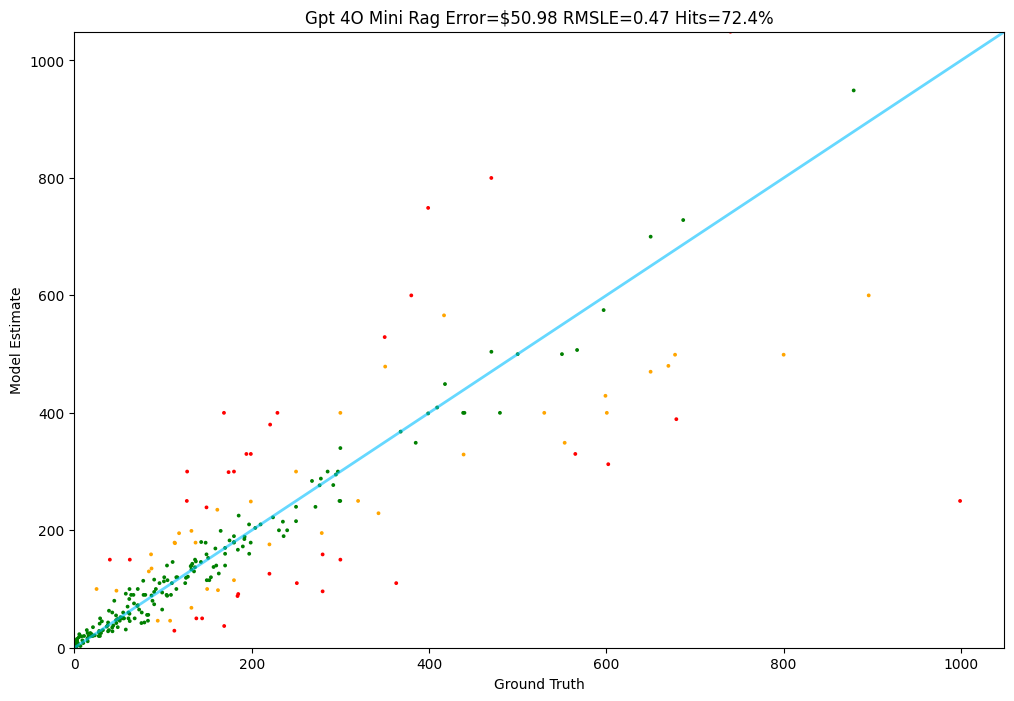

In [70]:
Tester.test(gpt_4o_mini_rag, test)

### Wrap this to Agent Class

In [63]:
from agents.frontier_agent import FrontierAgent

In [64]:
# Let's print the logs so we can see what's going on

import logging
root = logging.getLogger()
root.setLevel(logging.INFO)

In [65]:
agent = FrontierAgent(collection)

INFO:root:[Frontier Agent] Initializing Frontier Agent
INFO:root:[Frontier Agent] Frontier Agent is setting up with OpenAI
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
INFO:root:[Frontier Agent] Frontier Agent is ready


In [66]:
agent.price("Quadcast HyperX condenser mic for high quality podcasting")

INFO:root:[Frontier Agent] Frontier Agent is performing a RAG search of the Chroma datastore to find 5 similar products


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:[Frontier Agent] Frontier Agent has found similar products
INFO:root:[Frontier Agent] Frontier Agent is about to call gpt-4o-mini with context including 5 similar products
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:[Frontier Agent] Frontier Agent completed - predicting $99.99


99.99

In [67]:
from agents.specialist_agent import SpecialistAgent

In [68]:
agent2 = SpecialistAgent()

INFO:root:[Specialist Agent] Specialist Agent is initializing - connecting to modal
INFO:root:[Specialist Agent] Specialist Agent is ready


In [69]:
agent2.price("Quadcast HyperX condenser mic for high quality podcasting")

INFO:root:[Specialist Agent] Specialist Agent is calling remote fine-tuned model
INFO:root:[Specialist Agent] Specialist Agent completed - predicting $189.00


189.0

# Day 4 - Bring Random Forest pricer and Create Ensembler model

In [71]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from items import Item
from testing import Tester
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib


In [72]:
# CONSTANTS

QUESTION = "How much does this cost to the nearest dollar?\n\n"
DB = "products_vectorstore"

In [73]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [74]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: Environment variable`H

In [75]:
# Another import after Logging in to Hugging Face - thank you Trung N.!

from items import Item

In [76]:
# Load in the test pickle file:

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [77]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [78]:
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
prices = [metadata['price'] for metadata in result['metadatas']]

In [79]:
# This next line takes an hour on my M1 Mac!
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(vectors, prices)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [80]:
# Save the model to a file
joblib.dump(rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [81]:
# Load it back in again
rf_model = joblib.load('random_forest_model.pkl')

In [82]:
from agents.specialist_agent import SpecialistAgent
from agents.frontier_agent import FrontierAgent
from agents.random_forest_agent import RandomForestAgent

In [83]:
specialist = SpecialistAgent()
frontier = FrontierAgent(collection)
random_forest = RandomForestAgent()

INFO:root:[Specialist Agent] Specialist Agent is initializing - connecting to modal
INFO:root:[Specialist Agent] Specialist Agent is ready
INFO:root:[Frontier Agent] Initializing Frontier Agent
INFO:root:[Frontier Agent] Frontier Agent is setting up with OpenAI
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
INFO:root:[Frontier Agent] Frontier Agent is ready
INFO:root:[Random Forest Agent] Random Forest Agent is initializing
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
INFO:root:[Random Forest Agent] Random Forest Agent is ready


In [84]:
def description(item):
    return item.prompt.split("to the nearest dollar?\n\n")[1].split("\n\nPrice is $")[0]

In [85]:
def rf(item):
    return random_forest.price(description(item))